In [1]:
import yaml

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import sys
from gnn_cp.data.data_manager import GraphDataManager
from gnn_cp.models.graph_models import GCN, GAT, APPNPNet, SAGE
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP


import numpy as np
import torch
import torch.nn.functional as F

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator


import sys
from original_example import GCN, SAGE

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


Torch is running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch is running on cuda


In [2]:
dataset_obj = PygNodePropPredDataset(name='ogbn-products',
                                    transform=T.ToSparseTensor())

edge_index = torch_geometric.utils.sort_edge_index(PygNodePropPredDataset(name='ogbn-products')[0].edge_index).to(device)
dataset = dataset_obj[0]

split_idx = dataset_obj.get_idx_split()
train_idx = split_idx['train']
test_idx = split_idx["test"]


In [3]:
model_name = 'GCN'

default_num_layers = 3
default_hidden_channels = 256
default_dropout = 0.5


if model_name == 'SAGE':
    model = SAGE(dataset_obj.num_features, default_hidden_channels,
                    dataset_obj.num_classes, default_num_layers,
                    default_dropout)
else:
    model = GCN(dataset_obj.num_features, default_hidden_channels,
                dataset_obj.num_classes, default_num_layers,
                default_dropout)

model.load_state_dict(torch.load("./GCN_model_0.pt"))

<All keys matched successfully>

In [4]:
if model_name == "GCN":
    # Pre-compute GCN normalization.
    adj_t = dataset.adj_t.set_diag()
    deg = adj_t.sum(dim=1).to(torch.float)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    adj_t = deg_inv_sqrt.view(-1, 1) * adj_t * deg_inv_sqrt.view(1, -1)
    dataset.adj_t = adj_t

In [5]:
splits = dataset_obj.get_idx_split()

In [6]:
model = model.to(device)
@torch.no_grad()
def get_output(model, data):
    model.eval()

    out = model(data.x.to(device), data.adj_t.to(device))

    return out

all_logits = get_output(model, dataset)
all_softmaxes = F.softmax(all_logits, dim=1)


y_true = dataset.y.squeeze()

In [7]:
accuracy = accuracy_score(y_true = y_true[test_idx].cpu().numpy(), y_pred = all_logits[test_idx].argmax(dim=1).cpu().numpy())
print(f"Accuracy: {accuracy}")

print(
    {
        "name": "OBGN Products",
        "n_nodes": dataset.x.shape[0],
        "n_attribs": dataset.x.shape[1],
        "n_edges": edge_index.shape[1],
        "n_classes": dataset.y.max().item() + 1,
        "n_labeled": np.round(((splits["train"].shape[0] + 2 * splits["valid"].shape[0]) / dataset.x.shape[0]) * 100, 2),
        "homophily": torch_geometric.utils.homophily(edge_index.cpu(), y_true.cpu() ), 
    }
)

Accuracy: 0.7584337923745567
{'name': 'OBGN Products', 'n_nodes': 2449029, 'n_attribs': 100, 'n_edges': 123718280, 'n_classes': 47, 'n_labeled': 11.24, 'homophily': 0.8075527548789978}


In [8]:
calib_fraction = 0.5

lambda_vals = np.arange(0, 1.51, 0.05).round(3)
coverage_values = np.arange(start=accuracy.round(2), stop=1.0, step=0.005).round(3)
fixed_neigh_coef = 0.55
selected_coverage = coverage_values[len(coverage_values)//2]


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric,
}

In [9]:
calib_fraction = np.round(splits["valid"].shape[0] / dataset.x.shape[0], 3)
calib_fraction

0.016

In [10]:
true_mask = F.one_hot(dataset.y.squeeze()).bool().to(device)
test_mask = true_mask[test_idx]
normal_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True)])

normal_scores = normal_cp.get_scores_from_logits(all_logits, test_idx)
normal_cp_results = normal_cp.shuffle_metrics_over_coverage(normal_scores, test_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)

mixing_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True), cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=edge_index, n_vertices=dataset.x.shape[0])])

mixing_scores = mixing_cp.get_scores_from_logits(all_logits, test_idx)
mixing_cp_results = mixing_cp.shuffle_metrics_over_coverage(mixing_scores, test_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)

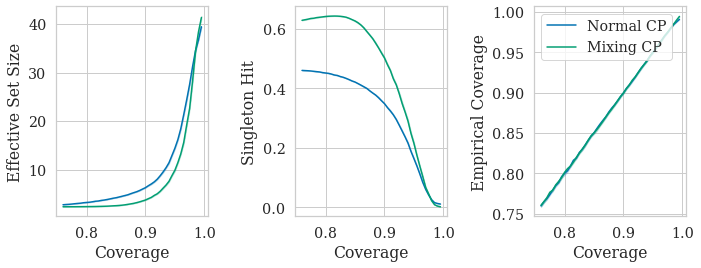

In [11]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)

f, axs = plt.subplots(1, 3, figsize=(10, 4))

sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Normal CP", color="#0173B2")
sns.lineplot(data=mixing_cp_results, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Mixing CP", color="#029E73")

sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Normal CP", color="#0173B2")
sns.lineplot(data=mixing_cp_results, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Mixing CP", color="#029E73")

sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="empi_coverage", ax=axs[2],label="Normal CP", color="#0173B2")
sns.lineplot(data=mixing_cp_results, x="coverage_guarantee", y="empi_coverage", ax=axs[2],label="Mixing CP", color="#029E73")

axs[0].set_xlabel("Coverage")
axs[0].set_ylabel("Effective Set Size")
axs[0].set_title("")

axs[1].set_xlabel("Coverage")
axs[1].set_ylabel("Singleton Hit")
axs[1].set_title("")

axs[2].set_xlabel("Coverage")
axs[2].set_ylabel("Empirical Coverage")
axs[2].set_title("")

axs[0].legend().remove()
axs[1].legend().remove()
axs[2].legend()

f.tight_layout()


## Comparison with RAPS

In [12]:
def compute_tune_calib_fraction(instance):
    tune_fraction = np.round(instance["train_idx"].shape[0] / instance["test_idx"].shape[0], 3)
    calib_fraction = np.round(instance["train_idx"].shape[0] / (instance["test_idx"].shape[0] - instance["train_idx"].shape[0]), 3)
    return tune_fraction, calib_fraction

def tune_truetest_split(test_idx, dataset, tuning_fraction):
    te_idx, tu_idx, _, _ = dataset_manager.train_test_split(test_idx, dataset.y[test_idx], training_fraction=tuning_fraction)
    return te_idx, tu_idx

In [13]:
def fair_shuffle_test_multiple_metrics(
    scores, y_true_mask, coverage_guarantee=0.92,
    n_iters=10, 
    metrics_dict={"set_size": lambda pred_set, true_mask: GraphCP.average_set_size(pred_set),
                  "coverage": lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask),
                  "argmax_accuracy": lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)},
    calib_fraction=0.5, tune_scores=None, tune_mask=None):
    
    result_df = []
    for iter_idx in range(n_iters):
        iteration_series = pd.Series({"attempt": iter_idx})
        calib_scores_sub, eval_scores, calib_ymask_sub, eval_ymask = GraphDataManager.train_test_split(
            scores, y_true_mask, training_fraction=calib_fraction, return_idx=False)
        calib_scores = calib_scores_sub if tune_scores is None else torch.concat([calib_scores_sub, tune_scores])
        calib_ymask = calib_ymask_sub if tune_mask is None else torch.concat([calib_ymask_sub, tune_mask])
        scores_quantile = GraphCP(transformation_sequence=[], coverage_guarantee=coverage_guarantee).calibrate_from_scores(calib_scores, calib_ymask)
        pred_set = eval_scores > scores_quantile
        for metric_name, metric_func in metrics_dict.items():
            result_val = metric_func(pred_set, eval_ymask)
            iteration_series[metric_name] = result_val
        result_df.append(iteration_series)

    result_df = pd.DataFrame(result_df)
    return result_df

# preparing first ingrediant of CP
def compare_cps(instance, dataset, coverage_val, lambda_val, k_reg, penalty, calib_fraction, true_test_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res


# preparing first ingrediant of CP
def compare_cps_fair(instance, dataset, coverage_val, lambda_val, k_reg, penalty, calib_fraction, true_test_idx, tune_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = fair_shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], 
                                                         coverage_guarantee=coverage_val,metrics_dict=metrics_dict, 
                                                         calib_fraction=calib_fraction, n_iters=n_iters, 
                                                         tune_scores=baseline_scores[tune_idx], tune_mask=label_mask[tune_idx])

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res

In [14]:
selected_coverage=0.92
k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

def find_all_regular_params(logit, dataset, coverage_val, tune_idx, n_iterations=20):
    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 1.5])
    
    label_mask = F.one_hot(dataset.y).bool()
    
    iteration_results = []
    overal_regular_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_sets = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overal_regular_results = [{"k_reg": 0, "penalty": 0, "average_set_size": base_cp.average_set_size(baseline_pred_sets)}]
        for k_reg in k_regs:
            for penalty in penalties:
                regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
                cp = GraphCP([], coverage_guarantee=selected_coverage)

                cp.calibrate_from_scores(regular_scores[tune_idx], label_mask[tune_idx])
                pred_set = cp.predict_from_scores(regular_scores[tune_idx])
                # print(cp.average_set_size(pred_set))

                overal_regular_results.append({
                    "k_reg": k_reg, "penalty": penalty,
                    "average_set_size": cp.average_set_size(pred_set)
                })
        overal_regular_results = pd.DataFrame(overal_regular_results)
        baseline_res = overal_regular_results.loc[(overal_regular_results["k_reg"] == 0) & (overal_regular_results["penalty"] == 0)]["average_set_size"].values[0]
        overal_regular_results["enhancement"] = overal_regular_results["average_set_size"] - baseline_res
        iteration_results.append(overal_regular_results[["enhancement"]])
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overal_regular_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["k_reg"], best_param_sets["penalty"])
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["k_reg"], best_param_series["penalty"])
    return overal_regular_results, best_params

def find_all_mixing_params(logit, dataset, coverage_val, tune_idx, n_iterations=20):
    lambda_vals = np.arange(0.05, 1, 0.05).round(3)
    label_mask = F.one_hot(dataset.y).bool()
    test_label_mask = label_mask[tune_idx]

    iteration_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_set = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overall_mixing_results = [{"lambda": 0, "average_set_size": base_cp.average_set_size(baseline_pred_set)}]
        for lambda_v in lambda_vals:
            mixing_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_v, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
            cp = regular_result = GraphCP([], coverage_guarantee=selected_coverage)

            cp.calibrate_from_scores(mixing_scores[tune_idx], label_mask[tune_idx])
            pred_set = cp.predict_from_scores(mixing_scores[tune_idx])
                # print(cp.average_set_size(pred_set))
            overall_mixing_results.append({
                "lambda": lambda_v,
                "average_set_size": cp.average_set_size(pred_set)
            })

        overall_mixing_results = pd.DataFrame(overall_mixing_results)
        baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
        overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
        iteration_results.append(overall_mixing_results[["enhancement"]])
        
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overall_mixing_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["lambda"], )
    #     baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
    #     overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["lambda"],)
    return overall_mixing_results, best_params


In [15]:
import os
config_file_dir = "../../baselines/config.yaml"
results_dir = "../../baselines/results"
figures_dir = "./../result-storage"
fair_network_results = os.path.join(figures_dir, "fair-network-results")

with open(config_file_dir, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
general_dataset_config = config.get("baseline", {}).get("general_dataset_config", {})


assert os.path.isdir(results_dir), "The results path does not exist!"

models_cache_dir = os.path.join(results_dir, "models")
assert os.path.isdir(models_cache_dir), "Directory to trained models is not found! Maybe first tun the make_baselines.py file"
data_dir = os.path.join(results_dir, "datasets")
assert os.path.isdir(data_dir), "Directory to Data Files is not found!"
splits_dir = os.path.join(results_dir, "splits")
assert os.path.isdir(splits_dir), "Directory to Data Splits is not found!"

dataset_manager = GraphDataManager(data_dir, splits_dir)

In [16]:
instance = {
    "train_idx": splits["train"],
    "val_idx": splits["valid"],
    "test_idx": splits["test"],
    "model": model,
}
format_adapted_dataset = torch_geometric.data.Data(x=dataset.x, y=dataset.y.squeeze(), edge_index=edge_index)
tune_fraction = np.round((instance["val_idx"].shape[0] * 1/3) / instance["test_idx"].shape[0], 3)

tune_idx, true_test_idx = tune_truetest_split(instance["test_idx"], format_adapted_dataset, tune_fraction)
calib_fraction = np.round((instance["val_idx"].shape[0] * 2/3) / test_idx.shape[0], 3)

In [17]:
overal_reg_result, best_reg_params = find_all_regular_params(all_logits, format_adapted_dataset, 0.85, tune_idx, n_iterations=20)

In [18]:
overal_mix_result, best_mix_params = find_all_mixing_params(all_logits, format_adapted_dataset, 0.85, tune_idx, n_iterations=20)

In [19]:
true_mask = F.one_hot(dataset.y.squeeze()).bool().to(device)
test_mask = true_mask[true_test_idx]

In [20]:
aps_scores = cp_t.APSTransformation(softmax=True).pipe_transform(all_logits)
raps_scores = cp_t.RegularizerPenalty(k_reg=best_reg_params[0], penalty=best_reg_params[1]).pipe_transform(aps_scores)
mixing_scores = cp_gt.VertexMPTransformation(
    neigh_coef=best_mix_params[0], edge_index=edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(aps_scores)

In [21]:
aps_overall_results = []
for coverage_v in coverage_values:
    aps_result = fair_shuffle_test_multiple_metrics(
        aps_scores[true_test_idx], true_mask[true_test_idx],
        coverage_guarantee=coverage_v, 
        metrics_dict=metrics_dict,
        calib_fraction=calib_fraction, tune_scores=aps_scores[tune_idx], tune_mask=true_mask[tune_idx], n_iters=10)
    aps_result["coverage_guarantee"] = coverage_v
    aps_overall_results.append(aps_result)
aps_result = pd.concat(aps_overall_results).reset_index().drop(columns="index")

In [22]:
raps_result = GraphCP([]).shuffle_metrics_over_coverage(
    raps_scores[true_test_idx], true_mask[true_test_idx], coverage_values, 
    metrics_dict=metrics_dict, calib_fraction=calib_fraction)

In [23]:
mixing_result = GraphCP([]).shuffle_metrics_over_coverage(
    mixing_scores[true_test_idx], true_mask[true_test_idx], coverage_values, 
    metrics_dict=metrics_dict, calib_fraction=calib_fraction)

In [24]:
aps_result

,attempt,empi_coverage,average_set_size,singleton_hit,coverage_guarantee
0,0.0,0.760190,2.772480,0.460276,0.760
1,1.0,0.760833,2.778983,0.460219,0.760
2,2.0,0.761053,2.780567,0.460173,0.760
3,3.0,0.758632,2.757684,0.460341,0.760
4,4.0,0.758246,2.754293,0.460328,0.760
...,...,...,...,...,...
475,5.0,0.990779,39.424133,0.010935,0.995
476,6.0,0.990785,39.425465,0.010924,0.995
477,7.0,0.990780,39.425617,0.010927,0.995
478,8.0,0.990782,39.425541,0.010938,0.995


In [25]:
raps_result

,attempt,empi_coverage,average_set_size,singleton_hit,coverage_guarantee
0,0.0,0.763777,2.440151,0.465445,0.760
1,1.0,0.760893,2.420052,0.465747,0.760
2,2.0,0.759709,2.412038,0.465880,0.760
3,3.0,0.761678,2.425692,0.465699,0.760
4,4.0,0.753966,2.374503,0.466274,0.760
...,...,...,...,...,...
475,5.0,0.994700,46.207375,0.000000,0.995
476,6.0,0.994854,46.224453,0.000000,0.995
477,7.0,0.995169,46.254539,0.000000,0.995
478,8.0,0.994984,46.236759,0.000000,0.995


In [26]:
mixing_result

,attempt,empi_coverage,average_set_size,singleton_hit,coverage_guarantee
0,0.0,0.759969,2.194499,0.687550,0.760
1,1.0,0.761089,2.193877,0.688123,0.760
2,2.0,0.759722,2.194602,0.687444,0.760
3,3.0,0.755411,2.194623,0.685212,0.760
4,4.0,0.759722,2.193454,0.687422,0.760
...,...,...,...,...,...
475,5.0,0.993337,40.488094,0.002329,0.995
476,6.0,0.993940,40.894268,0.002096,0.995
477,7.0,0.993930,40.895012,0.002091,0.995
478,8.0,0.995097,41.713764,0.001759,0.995


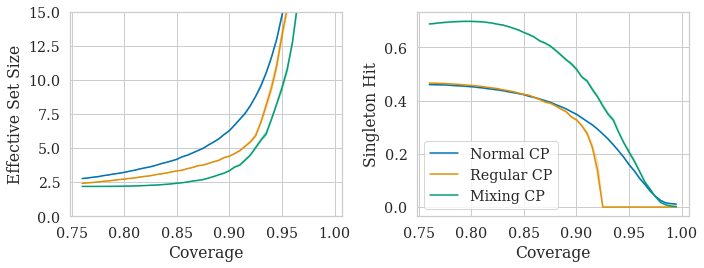

In [31]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)

f, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(data=aps_result, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Normal CP", color="#0173B2")
sns.lineplot(data=raps_result, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Regular CP", color="#DE8F05")
sns.lineplot(data=mixing_result, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Mixing CP", color="#029E73")

sns.lineplot(data=aps_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Normal CP", color="#0173B2")
sns.lineplot(data=raps_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Regular CP", color="#DE8F05")
sns.lineplot(data=mixing_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Mixing CP", color="#029E73")

# sns.lineplot(data=aps_result, x="coverage_guarantee", y="empi_coverage", ax=axs[2],label="Normal CP", color="#0173B2")
# sns.lineplot(data=raps_result, x="coverage_guarantee", y="empi_coverage", ax=axs[2],label="Regular CP", color="#DE8F05")
# sns.lineplot(data=mixing_result, x="coverage_guarantee", y="empi_coverage", ax=axs[2],label="Mixing CP", color="#029E73")

axs[0].set_xlabel("Coverage")
axs[0].set_ylabel("Effective Set Size")
axs[0].set_title("")

axs[1].set_xlabel("Coverage")
axs[1].set_ylabel("Singleton Hit")
axs[1].set_title("")

# axs[2].set_xlabel("Coverage")
# axs[2].set_ylabel("Empirical Coverage")
# axs[2].set_title("")

axs[0].legend().remove()
axs[1].legend()
# axs[2].legend()

axs[0].set_ylim(0, 15)

f.tight_layout()
plt.savefig(os.path.join(figures_dir, "ogbnproducts-mainpaper.pgf"), format="pgf", bbox_inches='tight')

In [28]:
true_test_idx.shape

torch.Size([2199813])